In [ ]:
from google.colab import drive
drive.mount('/content/drive')
# drive.flush_and_unmount()

Mounted at /content/drive


In [ ]:
cp -r '/content/drive/MyDrive/coco_dataset/images.zip' '/content'

In [ ]:
!unzip images.zip

In [ ]:
cp -r '/content/drive/MyDrive/coco_dataset/images_val.zip' '/content'

In [ ]:
!unzip images_val.zip

Archive:  images_val.zip
   creating: images_val/
  inflating: images_val/2104.jpg     
  inflating: images_val/161.jpg      
  inflating: images_val/3104.jpg     
  inflating: images_val/2274.jpg     
  inflating: images_val/86.jpg       
  inflating: images_val/1626.jpg     
  inflating: images_val/1778.jpg     
  inflating: images_val/2183.jpg     
  inflating: images_val/2203.jpg     
  inflating: images_val/854.jpg      
  inflating: images_val/1556.jpg     
  inflating: images_val/1806.jpg     
  inflating: images_val/2114.jpg     
  inflating: images_val/3097.jpg     
  inflating: images_val/2511.jpg     
  inflating: images_val/680.jpg      
  inflating: images_val/3156.jpg     
  inflating: images_val/3126.jpg     
  inflating: images_val/128.jpg      
  inflating: images_val/1058.jpg     
  inflating: images_val/1303.jpg     
  inflating: images_val/630.jpg      
  inflating: images_val/3184.jpg     
  inflating: images_val/2276.jpg     
  inflating: images_val/998.jpg      


In [ ]:
cp -r '/content/drive/MyDrive/yolo_algorithm/resnet_yolo (1).py' '/content'

In [ ]:
cp -r '/content/drive/MyDrive/yolo_algorithm/dataset (1).py' '/content'

In [ ]:
cp -r '/content/drive/MyDrive/yolo_algorithm/config (1).py' '/content'

In [ ]:
cp -r '/content/drive/MyDrive/yolo_algorithm/yolo_loss (1).py' '/content'

In [ ]:
cp -r '/content/drive/MyDrive/yolo_algorithm/predict (1).py' '/content'

In [ ]:
cp -r '/content/drive/MyDrive/yolo_algorithm/eval_coco (1).py' '/content'

In [ ]:
cp -r '/content/drive/MyDrive/yolo_algorithm/train_data.txt' '/content'

In [ ]:
cp -r '/content/drive/MyDrive/yolo_algorithm/val_data.txt' '/content'

In [ ]:
cp -r '/content/drive/MyDrive/LatestModels/detector_on_coco_v7.pth' '/content'

In [ ]:
import os
import random
import cv2
import numpy as np

In [ ]:
import torch
from torch.utils.data import DataLoader
from torchvision import models

In [ ]:
from dataset import CocoDetectorDataset
from eval_coco import evaluate
from predict import predict_image
from resnet_yolo import resnet50
from yolo_loss import YoloLoss
from config import COCO_CLASSES, COLORS

In [ ]:
import matplotlib.pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
# Yolo Algorithm parameters
B = 2  # number of bounding boxs per cell
S = 14  # width/height of network output matrix (larger than 7x7)

In [ ]:
load_network_path = '/content/detector_on_coco_v7.pth'
# load_network_path = None
pretrained = True

# use to load a previously trained network
if load_network_path is not None:
    print('Loading saved network from {}'.format(load_network_path))
    net = resnet50().to(device)
    net.load_state_dict(torch.load(load_network_path))
else:
    print('Loaded the pre-trained Imagenet model')
    net = resnet50(pretrained=pretrained).to(device)

Loading saved network from /content/detector_on_coco_v7.pth


In [ ]:
from torchsummary import summary
summary(net,(3,448,448))

In [ ]:
net

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
learning_rate = 0.001
num_epochs = 3
batch_size = 12

# Yolo loss component coefficients (standard coefficients)
lambda_coord = 5
lambda_noobj = 0.5

In [ ]:
criterion = YoloLoss(S, B, lambda_coord, lambda_noobj)
optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9, weight_decay=5e-4)

In [ ]:
# file_root_train = 'VOCdevkit_2007/VOC2007/JPEGImages/'
file_root_train = 'images'
annotation_file_train = 'train_data.txt'

train_dataset = CocoDetectorDataset(root_img_dir=file_root_train,dataset_file=annotation_file_train,train=True, S=S)
train_loader = DataLoader(train_dataset,batch_size=batch_size,shuffle=True)
print('Loaded %d train images' % len(train_dataset))

In [ ]:
file_root_test = 'images_val'
annotation_file_test = 'val_data.txt'

test_dataset = CocoDetectorDataset(root_img_dir=file_root_test,dataset_file=annotation_file_test,train=False, S=S)
test_loader = DataLoader(test_dataset,batch_size=batch_size,shuffle=False)
print('Loaded %d test images' % len(test_dataset))

In [ ]:
best_test_loss = np.inf
best_test_losses = []
for epoch in range(num_epochs):
    net.train()
    
    # Update learning rate late in trainning
    if epoch == 30 or epoch == 40:
        learning_rate /= 10.0

    for param_group in optimizer.param_groups:
        param_group['lr'] = learning_rate
    
    print('\n\nEpoch %d / %d' % (epoch + 1, num_epochs))
    print('Learning Rate for this epoch: {}'.format(learning_rate))
    
    total_loss = 0.
    
    for i, (images, target) in enumerate(train_loader):
        images, target = images.to(device), target.to(device)
        pred = net(images)
        loss = criterion(pred,target)
        total_loss += loss.item()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if (i+1) % 5 == 0:
            print('Epoch [%d/%d], Iter [%d/%d] Loss: %.4f, average_loss: %.4f'
                  % (epoch+1, num_epochs, i+1, len(train_loader), loss.item(), total_loss / (i+1)))
    
    # evaluate the network on the test data
    with torch.no_grad():
        test_loss = 0.0
        net.eval()
        for i, (images, target) in enumerate(test_loader):
            images, target = images.to(device), target.to(device)

            pred = net(images)
            loss = criterion(pred,target)
            test_loss += loss.item()
        test_loss /= len(test_loader)
    
    if best_test_loss > test_loss:
        best_test_loss = test_loss
        print('Updating best test loss: %.5f' % best_test_loss)
        torch.save(net.state_dict(),'best_detector_on_coco_v3.pth')
        

          
    print(test_loss)
    best_test_losses.append(test_loss)

    torch.save(net.state_dict(),'detector_on_coco_v3.pth')
    




Epoch 1 / 3
Learning Rate for this epoch: 0.001


/content/yolo_loss.py:89: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/IndexingUtils.h:30.)
  noobj_pred_conf = noobj_pred[noobj_conf_mask]       # [n_noobj, 2=len([conf1, conf2])]
/content/yolo_loss.py:90: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/IndexingUtils.h:30.)
  noobj_target_conf = noobj_target[noobj_conf_mask]   # [n_noobj, 2=len([conf1, conf2])]
/content/yolo_loss.py:128: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/IndexingUtils.h:30.)
  bbox_pred_response = bbox_pred[coord_response_mask].view(-1, 5)      # [n_response, 5]
/content/yolo_loss.py:129: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torc

Epoch [1/3], Iter [5/6551] Loss: 2.5395, average_loss: 2.6503
Epoch [1/3], Iter [10/6551] Loss: 1.2521, average_loss: 2.2963
Epoch [1/3], Iter [15/6551] Loss: 1.7702, average_loss: 2.2419
Epoch [1/3], Iter [20/6551] Loss: 2.4040, average_loss: 2.2931
Epoch [1/3], Iter [25/6551] Loss: 2.1611, average_loss: 2.4942
Epoch [1/3], Iter [30/6551] Loss: 3.2792, average_loss: 2.5591
Epoch [1/3], Iter [35/6551] Loss: 3.1217, average_loss: 2.6406
Epoch [1/3], Iter [40/6551] Loss: 1.6236, average_loss: 2.6252
Epoch [1/3], Iter [45/6551] Loss: 3.3231, average_loss: 2.6592
Epoch [1/3], Iter [50/6551] Loss: 1.8365, average_loss: 2.6621
Epoch [1/3], Iter [55/6551] Loss: 3.6535, average_loss: 2.7114
Epoch [1/3], Iter [60/6551] Loss: 4.3651, average_loss: 2.7857
Epoch [1/3], Iter [65/6551] Loss: 1.8158, average_loss: 2.7487
Epoch [1/3], Iter [70/6551] Loss: 2.9020, average_loss: 2.7742
Epoch [1/3], Iter [75/6551] Loss: 4.2166, average_loss: 2.8170
Epoch [1/3], Iter [80/6551] Loss: 2.0219, average_loss: 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
cp -r  '/content/detector_on_coco_v3.pth' '/content/drive/MyDrive/Project_files/yolo_algorithm'

In [ ]:
cp -r  '/content/best_detector_on_coco_v3.pth' '/content/drive/MyDrive/Project_files/yolo_algorithm'

predicting...
images_val


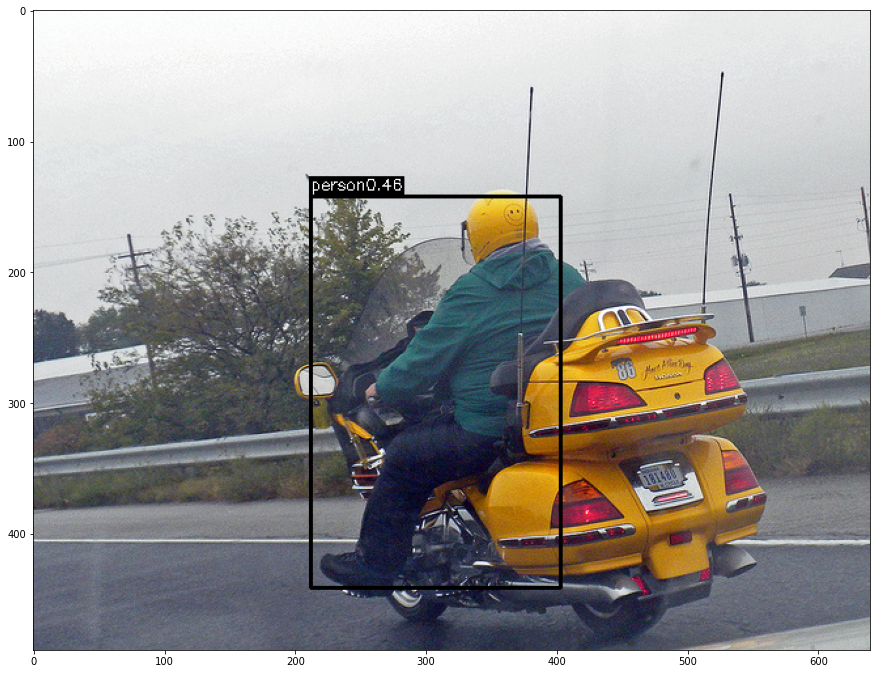

In [ ]:
net.eval()

# select random image from test set
image_name = random.choice(test_dataset.fnames)
image = cv2.imread(os.path.join(file_root_test, image_name))

image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

print('predicting...')
print(file_root_test)
result = predict_image(net, image_name, root_img_directory=file_root_test)
for left_up, right_bottom, class_name, _, prob in result:
    color = COLORS[COCO_CLASSES.index(class_name)]
    cv2.rectangle(image, left_up, right_bottom, color, 2)
    label = class_name + str(round(prob, 2))
    text_size, baseline = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.4, 1)
    p1 = (left_up[0], left_up[1] - text_size[1])
    cv2.rectangle(image, (p1[0] - 2 // 2, p1[1] - 2 - baseline), (p1[0] + text_size[0], p1[1] + text_size[1]),
                  color, -1)
    cv2.putText(image, label, (p1[0], p1[1] + baseline), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255, 255, 255), 1, 8)

plt.figure(figsize = (15,15))
plt.imshow(image)


In [ ]:
test_aps = evaluate(net, test_dataset_file=annotation_file_test)

---Evaluate model on test samples---


100%|██████████| 3357/3357 [01:38<00:00, 33.98it/s]


---class person ap 0.6133291528940201---
---class bicycle ap 0.2459286332226221---
---class car ap 0.4227326767676697---
---class dog ap 0.630862406067567---
---class horse ap 0.5223068134709519---
---class chair ap 0.22081246939048---
---class laptop ap 0.47451647912123934---
---class mouse ap 0.4980084319530861---
---class keyboard ap 0.5198584606941563---
---class book ap 0.08428747982999552---
---map 0.4232643003411788---


In [ ]:
test_aps = evaluate(net, test_dataset_file=annotation_file_test)

---Evaluate model on test samples---


100%|██████████| 3357/3357 [01:38<00:00, 34.11it/s]


---class person ap 0.6360130547345657---
---class bicycle ap 0.2594295845759588---
---class car ap 0.4465782589925447---
---class dog ap 0.6344123536400336---
---class horse ap 0.5308779205153633---
---class chair ap 0.23480461293942398---
---class laptop ap 0.47598708325106454---
---class mouse ap 0.502010718974241---
---class keyboard ap 0.5448965473961712---
---class book ap 0.10625463329482406---
---map 0.4371264768314192---


In [ ]:
test_aps

[0.6133291528940201,
 0.2459286332226221,
 0.4227326767676697,
 0.630862406067567,
 0.5223068134709519,
 0.22081246939048,
 0.47451647912123934,
 0.4980084319530861,
 0.5198584606941563,
 0.08428747982999552]

In [ ]:
 torch.cuda.empty_cache()